In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import datetime as dt

from shapely.geometry import Point,Polygon
#import following libraries
import geopandas as gpd
from geopy.exc import GeocoderTimedOut, GeocoderUnavailable, GeocoderServiceError
from geopy.geocoders import Nominatim 
import time
from pprint import pprint
import folium

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

#import os
#for dirname, _, filenames in os.walk('/kaggle/input'):
#    for filename in filenames:
 #       print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
#filepath = 'fatalities_isr_pse_conflict_2000_to_2023'
df = pd.read_csv("fatalities_isr_pse_conflict_2000_to_2023.csv") 
war = df.copy() #create copy

In [3]:
import os

current_directory = os.getcwd()
print("Current working directory:", current_directory)


Current working directory: C:\Users\PC\Documents\KAGGLE PROJECTS\Fatalities in the Israeli-Palestinian


# About Dataset

### Some Task Ideas:
1. **Analyze Fatality Trends**: Explore the dataset and track the trends in fatalities over time. Identify any significant changes, spikes, or declines in the number of fatalities.

2. **Demographic Analysis**:Conduct a demographic analysis by examining the age, gender, and citizenship of the individuals killed. Determine if there are any notable patterns or disparities in the data.

3. **Geospatial Analysis**: Utilize the event location, district, and region information to perform geospatial analysis. Visualize the distribution of fatalities on a map and identify areas that have experienced higher levels of violence.

4. **Hostilities Participation Analysis**:Investigate the extent of individuals' participation in hostilities before their deaths. Analyze the relationship between participation and the circumstances surrounding each fatality.

5. **Injury Analysis**: Examine the types of injuries inflicted on individuals. Identify the most common types of injuries and assess their severity.

6. **Weapons Used**: Analyze the ammunition and means by which the individuals were killed. Determine the most frequently used weapons or methods and evaluate their impact.

7. **Victim Profiles**: Create profiles of the victims based on the available data such as age, gender, citizenship, and place of residence. Identify common characteristics among the victims.

## 1. Cleaning

We will be doing the following;

1. address missing values 
2. check for duplicate values
3. check data type

In [4]:
war['date_of_event'] = pd.to_datetime(
    war['date_of_event'], errors='coerce')

In [5]:
war['date_of_death'] = pd.to_datetime(
    war['date_of_death'], errors='coerce')

Just to be as accurate as possible, I am going to drop the null rows in the `age` column

In [6]:
war.dropna(subset=['age'], inplace=True) #drop empty rows in age column

The rest of the information we can fill with 'Unknown'. After all, this is a war and it is impossible to have all the answers in real time

In [7]:
war = war.fillna('Unknown')

### 1. **Analyze Fatality Trends**: 

Explore the dataset and track the trends in fatalities over time. Identify any significant changes, spikes, or declines in the number of fatalities.

first, let's check if the `date_of_event` has the same data as `date_of_death`

In [8]:
#war[war['date_of_event'] != war['date_of_death']]

The columns are not the same. Let's start by checking death over time. let's create a new column 'Year' to check with year had the most death

In [9]:
war['year'] = war['date_of_event'].dt.year

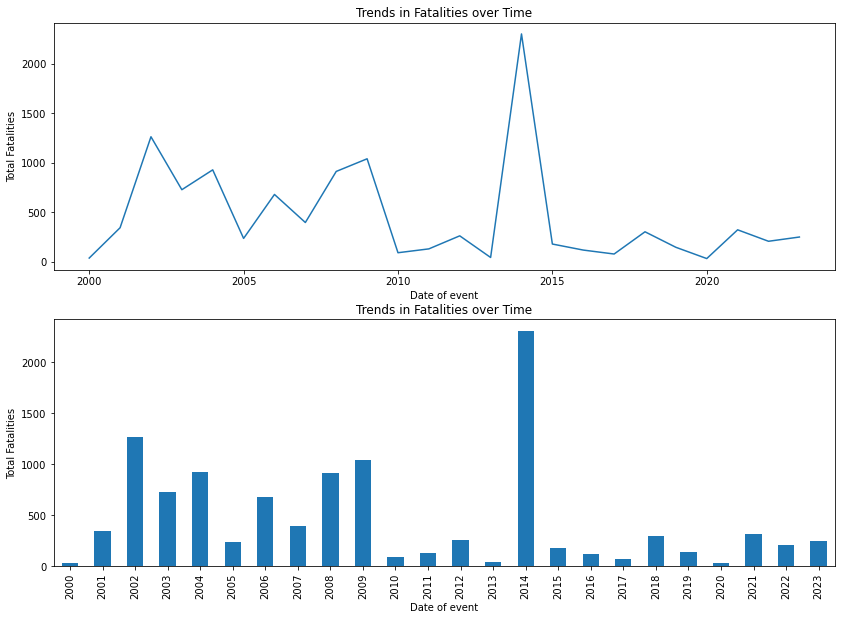

In [10]:
# Group the data by 'date_of_event' and count the occurrences to get the count of fatalities per day
fatalities_over_time = war.groupby('year').size()

# Plot the trend
plt.subplots(figsize=(14,10))

plt.subplot(2,1,1)
fatalities_over_time.plot(kind='line')
plt.title('Trends in Fatalities over Time')
plt.xlabel('Date of event')
plt.ylabel('Total Fatalities');


plt.subplot(2,1,2)
fatalities_over_time.plot(kind='bar')
plt.title('Trends in Fatalities over Time')
plt.xlabel('Date of event')
plt.ylabel('Total Fatalities');

### 2. **Demographic Analysis**:

Conduct a demographic analysis by examining the age, gender, and citizenship of the individuals killed. Determine if there are any notable patterns or disparities in the data.

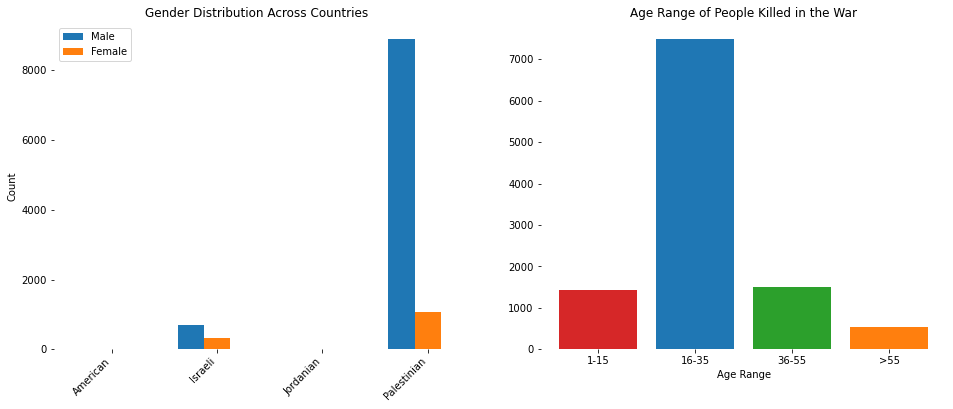

In [100]:
# Plot the trend
country_gender_counts = war.groupby(['citizenship', 'gender']).size().unstack()

# Extract data for plotting
countries = country_gender_counts.index.tolist()
male_counts = country_gender_counts['M'].fillna(0).tolist()
female_counts = country_gender_counts['F'].fillna(0).tolist()

x = np.arange(len(countries))  # the label locations
width = 0.25  # the width of the bars

fig, axs = plt.subplots(1, 2, figsize=(16, 6))  # Create a 1x2 grid of subplots

# Plot bars for each gender in the first subplot
rects1 = axs[0].bar(x - width, male_counts, width, label='Male')
rects2 = axs[0].bar(x, female_counts, width, label='Female')

# Customize the first subplot
axs[0].set_ylabel('Count')
axs[0].set_xticks(x)
axs[0].set_xticklabels(countries, rotation=45, ha="right")
axs[0].set_title("Gender Distribution Across Countries")
axs[0].legend()

# Remove spines for the first subplot
for location in ['top', 'bottom', 'left', 'right']:
    axs[0].spines[location].set_visible(False)

# Assuming 'war' is your DataFrame
war['age_range'] = pd.cut(war['age'], bins=[0, 15, 35, 55, float('inf')],
                          labels=['1-15', '16-35', '36-55', '>55'], include_lowest=True)

# Plot the age range graph in the second subplot
age = war['age_range'].value_counts().sort_index()

age_range = age.index.tolist()
age_counts = age.values.tolist()
bar_colors = ['tab:red', 'tab:blue', 'tab:green', 'tab:orange']

axs[1].bar(age_range, age_counts, color=bar_colors)

# Customize the second subplot
axs[1].set_xlabel('Age Range')
axs[1].set_title('Age Range of People Killed in the War')

# Remove spines for the second subplot
for location in ['top', 'bottom', 'left', 'right']:
    axs[1].spines[location].set_visible(False)

plt.show()


### 3. **Geospatial Analysis**: 

Utilize the event location, district, and region information to perform geospatial analysis. Visualize the distribution of fatalities on a map and identify areas that have experienced higher levels of violence.

In [15]:
#!pip install geopandas

#!pip install geopy 

In [16]:
### UNCOMMENT THIS CODE TO RUN

#war_areas = war[['event_location','event_location_district','event_location_region']]

## Remove ' at the beginning of the string and "r.c." at the end of the string in the 'event_location' column
#war_areas.loc[:,'event_location'] = war_areas['event_location'].str.replace(r"^\'+|\s+R\.C\.$", '', regex=True)

## Combine 'event_location' and 'event_location_district' columns
#war_areas.loc[:,'region_combined'] = war_areas['event_location'] + ',' + war_areas['event_location_region']

In [17]:
#unique_regions = war_areas['region_combined'].unique()

## Maximum number of attempts
#max_attempts = 50

# Your existing code
#latitude_dict = {}
#longitude_dict = {}

#def findGeocode(city):
#    attempts = 0
#    while attempts < max_attempts:
#        try:
#            geolocator = Nominatim(user_agent="war areas")
#            location = geolocator.geocode(city)
#            if location:
#                return location.raw
#            else:
#                return None
#        except GeocoderTimedOut as e:
#            print("Timeout error. Retrying...")
#            time.sleep(1)  # Wait for a second before retrying
#            attempts += 1
#        except (GeocoderUnavailable, GeocoderServiceError) as e:
#            print("Geocoder service is unavailable. Check your internet connection or try again later.")
#            return None
#    return None  # Return None if maximum attempts are reached without success

## Let's apply our function
#for region in unique_regions: 
#    location = findGeocode(region)
#    if location:
#        latitude_dict[region] = location['lat']
#        longitude_dict[region] = location['lon']
#    else:
#        latitude_dict[region] = np.nan
#        longitude_dict[region] = np.nan

In [18]:
#UNCOMMENT TO RUN CODE!!!

## Create new columns in the war_areas DataFrame
#war_areas.loc[:,'latitude'] = war_areas['region_combined'].map(latitude_dict)
#war_areas.loc[:,'longitude'] = war_areas['region_combined'].map(longitude_dict)

##export the war_areas as csv file

#war_areas.to_csv('war_areas_geo.csv',index = False)

----

In [19]:
war_areas = pd.read_csv('war_areas_geo.csv')
df = war_areas.copy()
df.drop('region_combined',axis=1,inplace=True)

In [20]:
# Combining Lattitude and Longitude to create hurricane coordinates:
df['coordinates'] = df[['longitude', 'latitude']].values.tolist()

In [21]:
# Change the coordinates to a GeoPoint
df['coordinates'] = df['coordinates'].apply(Point)

# Create a bounding box around the centroid (you can adjust the size as needed)
buffer_distance = 0.1  # Adjust the buffer distance based on your requirements
df['bounding_box'] = df['coordinates'].apply(lambda point: point.buffer(buffer_distance))

# Create a Polygon using the bounding box
df['polygon_geometry'] = df['bounding_box'].apply(lambda box: Polygon(box.exterior))

In [25]:
# Convert the count df to geodf
geo_df = gpd.GeoDataFrame(df)

#set geometry
geo_df = geo_df.set_geometry('polygon_geometry') 

In [26]:
# Create the dictionary
district_coords = {}
for district in df['event_location_district'].unique():
    district_data = df[df['event_location_district'] == district]
    mean_latitude = district_data['latitude'].mean()
    mean_longitude = district_data['longitude'].mean()
    district_coords[district] = [mean_latitude, mean_longitude]

In [28]:
district_fatalities = df.groupby('event_location_district').size()

# Function to determine the color of the circle based on the number of fatalities
def get_color(fatalities):
    if fatalities > 1000:
        return 'darkred'
    elif 500 <= fatalities <= 1000:
        return 'green'
    elif 50 <= fatalities < 500:
        return 'orange'
    else:
        return 'grey'


m = folium.Map(location=[32, 34.75], zoom_start=8)

# maker, tooltip 
for district, coords in district_coords.items():
    fatalities = district_fatalities.get(district, 0)
    folium.Marker(
        location=coords,
        tooltip=f'District: {district}, Fatalities: {fatalities}',
        icon=None
    ).add_to(m)
    folium.Circle(
        location=coords,
        radius=np.sqrt(fatalities) * 1200,
        color=get_color(fatalities),
        fill=True,
        fill_color=get_color(fatalities),
        fill_opacity=0.6,
    ).add_to(m)


folium.LayerControl().add_to(m)

m

For more information on Geo spatial analysis, check out the fllowing articles:

1. https://www.datacamp.com/tutorial/geospatial-data-python
2. https://www.datacamp.com/tutorial/geopandas-tutorial-geospatial-analysis
3. https://www.learndatasci.com/tutorials/geospatial-data-python-geopandas-shapely/
4. https://towardsdatascience.com/geospatial-analysis-in-python-and-jupyter-notebooks-f90de25b0777

### 4. **Hostilities Participation Analysis**:

Investigate the extent of individuals' participation in hostilities before their deaths. Analyze the relationship between participation and the circumstances surrounding each fatality.

In [101]:
war['took_part_in_the_hostilities'] = war['took_part_in_the_hostilities'].replace('Israelis', 'No')

In [102]:
from matplotlib.patches import ConnectionPatch

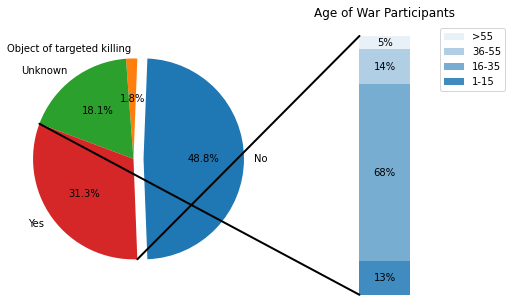

In [103]:
# Filter DataFrame for those who participated in the war ('yes')
war_participants = war[war['took_part_in_the_hostilities'] == 'Yes']

# Calculate age distribution of war participants
age_distribution = war['age_range'].value_counts(normalize=True).sort_index()
war_distribution = war['took_part_in_the_hostilities'].value_counts(normalize=True).sort_index()

# make figure and assign axis objects
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(9, 5))
fig.subplots_adjust(wspace=0)

# pie chart parameters
overall_ratios = war_distribution.values.tolist()
labels = ['No', 'Object of targeted killing', 'Unknown', 'Yes'] #war_distribution.index.tolist()

explode = [0.1, 0, 0, 0]
# rotate so that the first wedge is split by the x-axis
angle = -180 * overall_ratios[0]
wedges, *_ = ax1.pie(overall_ratios, autopct='%1.1f%%', startangle=angle,
                     labels=labels, explode=explode)

# bar chart parameters
age_labels = age_distribution.index.tolist()
age_ratios = age_distribution.values.tolist()
bottom = 1
width = 0.2

# Adding from the top matches the legend.
for j, (height, label) in enumerate(reversed([*zip(age_ratios, age_labels)])):
    bottom -= height
    bc = ax2.bar(0, height, width, bottom=bottom, color='C0', label=label,
                 alpha=0.1 + 0.25 * j)
    ax2.bar_label(bc, labels=[f"{height:.0%}"], label_type='center')

ax2.set_title('Age of War Participants')
ax2.legend()
ax2.axis('off')
ax2.set_xlim(-2.5 * width, 2.5 * width)

# use ConnectionPatch to draw lines between the two plots
theta1, theta2 = wedges[3].theta1, wedges[3].theta2 #connect to 'yes'
center, r = wedges[3].center, wedges[3].r
bar_height = sum(age_ratios)

# draw top connecting line
x = r * np.cos(np.pi / 180 * theta2) + center[0]
y = r * np.sin(np.pi / 180 * theta2) + center[1]
con = ConnectionPatch(xyA=(-width / 2, bar_height), coordsA=ax2.transData,
                      xyB=(x, y), coordsB=ax1.transData)
con.set_color([0, 0, 0])
con.set_linewidth(2)
ax2.add_artist(con)

# draw bottom connecting line
x = r * np.cos(np.pi / 180 * theta1) + center[0]
y = r * np.sin(np.pi / 180 * theta1) + center[1]
con = ConnectionPatch(xyA=(-width / 2, 0), coordsA=ax2.transData,
                      xyB=(x, y), coordsB=ax1.transData)
con.set_color([0, 0, 0])
ax2.add_artist(con)
con.set_linewidth(2)

plt.show()

### 5. **Injury Analysis**: 

Examine the types of injuries inflicted on individuals. Identify the most common types of injuries and assess their severity.



In [ ]:
#from matplotlib import colormaps
#list(colormaps)

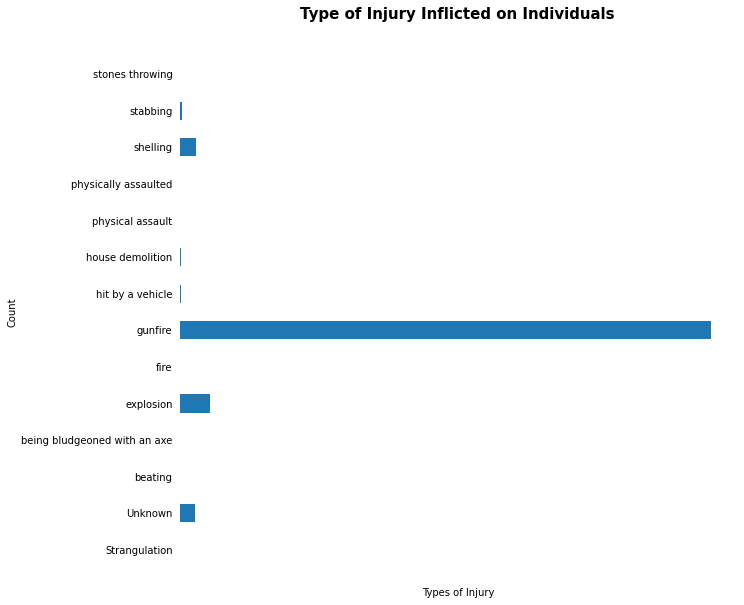

In [106]:
injury_distribution = war['type_of_injury'].value_counts(normalize=True).sort_index()

x= injury_distribution.index.tolist()
y = injury_distribution.values.tolist()

fig, ax = plt.subplots(figsize=(10,10))
bar_container = ax.barh(x,y, height =0.5); #visit https://html-color.codes/ to choose any hex color 
ax.set(xlabel='Types of Injury',ylabel= 'Count')

#remove spines
for location in ['top','bottom','left','right']:
    ax.spines[location].set_visible(False)
    
#remove x and y ticks
ax.tick_params(bottom=False,left=False)
ax.set_xticks([])  # Remove x-ticks

#set titles
ax.text(x=0.2, y=14.5, s='Type of Injury Inflicted on Individuals',
        size=15, weight='bold');

### 6. **Weapons Used**: 

Analyze the ammunition and means by which the individuals were killed. Determine the most frequently used weapons or methods and evaluate their impact.


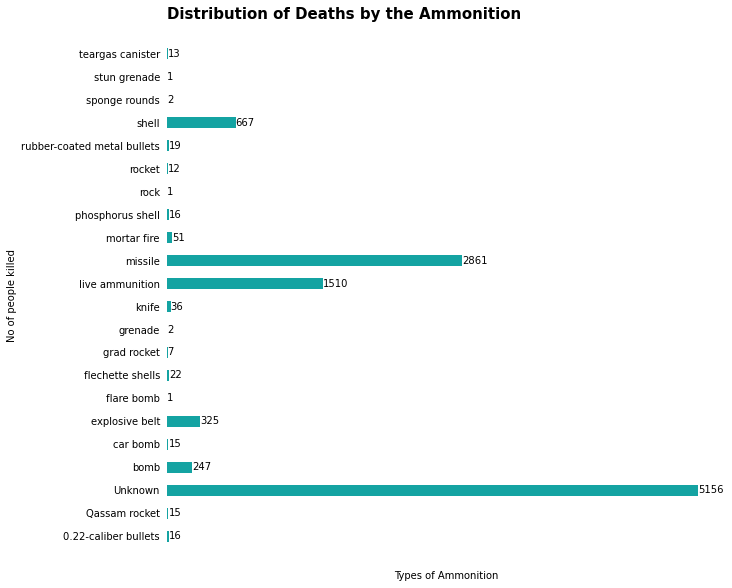

In [107]:
ammonition_dist = war['ammunition'].value_counts().sort_index()

x= ammonition_dist.index.tolist()
y = ammonition_dist.values.tolist()

fig, ax = plt.subplots(figsize=(10,10))
bar_container = ax.barh(x,y, height =0.5, color='#14a3a2'); #visit https://html-color.codes/ to choose any hex color 
ax.set(xlabel='Types of Ammonition',ylabel= 'No of people killed')

# Add count labels beside the bars
for index, value in enumerate(y):
    ax.text(value, index, f'{value}', va='center')

#remove spines
for location in ['top','bottom','left','right']:
    ax.spines[location].set_visible(False)
    
#remove x and y ticks
ax.tick_params(bottom=False,left=False)
ax.set_xticks([])  # Remove x-ticks

#set titles
ax.text(x=0.15, y=22.5, s='Distribution of Deaths by the Ammonition',
        size=15, weight='bold');

### 7. **Victim Profiles**: 

Create profiles of the victims based on the available data such as age, gender, citizenship, and place of residence. Identify common characteristics among the victims.